In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df =pd.read_csv(r"/cleaned_sleep_data.csv")
df

,series_id,step,timestamp,anglez,enmo,sleep
0,038441c925bb,4992,2018-08-15 02:26:00+00:00,-78.6906,0.0099,onset
1,038441c925bb,10932,2018-08-15 10:41:00+00:00,-61.5782,0.0263,wakeup
2,038441c925bb,20244,2018-08-15 23:37:00+00:00,-6.3874,0.0182,onset
3,038441c925bb,27492,2018-08-16 09:41:00+00:00,-45.3551,0.0165,wakeup
4,038441c925bb,39996,2018-08-17 03:03:00+00:00,-1.7867,0.0000,onset
...,...,...,...,...,...,...
9580,fe90110788d2,547152,2017-09-05 13:26:00+00:00,-56.7689,0.0042,wakeup
9581,fe90110788d2,556560,2017-09-06 02:30:00+00:00,-16.5867,0.0000,onset
9582,fe90110788d2,560604,2017-09-06 08:07:00+00:00,-43.0509,0.0000,wakeup
9583,fe90110788d2,574620,2017-09-07 03:35:00+00:00,1.5191,0.0066,onset


In [ ]:
df.head()

,series_id,step,timestamp,anglez,enmo,sleep
0,038441c925bb,4992,2018-08-15 02:26:00+00:00,-78.6906,0.0099,onset
1,038441c925bb,10932,2018-08-15 10:41:00+00:00,-61.5782,0.0263,wakeup
2,038441c925bb,20244,2018-08-15 23:37:00+00:00,-6.3874,0.0182,onset
3,038441c925bb,27492,2018-08-16 09:41:00+00:00,-45.3551,0.0165,wakeup
4,038441c925bb,39996,2018-08-17 03:03:00+00:00,-1.7867,0.0000,onset


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9585 non-null   object 
 1   step       9585 non-null   int64  
 2   timestamp  9585 non-null   object 
 3   anglez     9585 non-null   float64
 4   enmo       9585 non-null   float64
 5   sleep      9585 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 449.4+ KB


In [ ]:
df.describe()

,step,anglez,enmo
count,9585.000000,9585.000000,9585.000000
mean,214352.123944,-9.713789,0.014887
std,141268.408192,45.969550,0.034452
min,936.000000,-84.653400,0.000000
25%,95436.000000,-48.502800,0.000000
50%,200604.000000,-16.017700,0.001300
75%,317520.000000,28.466300,0.017400
max,739392.000000,78.912700,0.394300


In [ ]:
# Split out X / y
X = df.drop(columns=["sleep"])
y = df["sleep"]

In [ ]:
print(y.value_counts(normalize=True))  # Shows proportion
print(y.value_counts())               # Shows actual counts

sleep
wakeup    0.500156
onset     0.499844
Name: proportion, dtype: float64
sleep
wakeup    4794
onset     4791
Name: count, dtype: int64


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Define the feature columns for prediction
features = ["enmo", "anglez"]
selector = VarianceThreshold(threshold=0.001)

# Fit the selector to your selected features
selector.fit(X[features])
selected_features = [feature for feature, keep in zip(features, selector.get_support()) if keep]
print("Selected Features after Variance Threshold:", selected_features)

Selected Features after Variance Threshold: ['enmo', 'anglez']


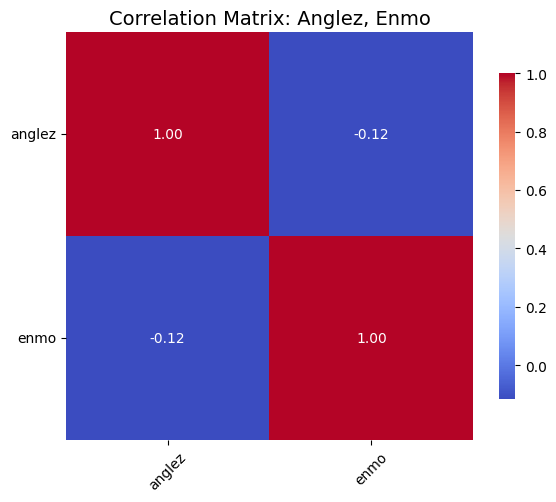

In [ ]:
# 2. Correlation Matrix
# Define the features to include in the correlation matrix
features = ["anglez", "enmo"]
corr = X[features].corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix: Anglez, Enmo" ,fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Separate input features (X) and output target (y)
X = df[["anglez", "enmo"]]
y = df['sleep']

# 2. Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4. Define preprocessing for numeric features
numeric_features = ["anglez", "enmo"]
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# 5. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ])

# 6. Create final Preprocessing Pipeline
preprocessing_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# 7. Fit and transform the train data, transform the test data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)


In [ ]:
print(le.classes_)
print(dict(zip(le.classes_, le.transform(le.classes_))))

['onset' 'wakeup']
{'onset': np.int64(0), 'wakeup': np.int64(1)}


#### Step	   -   What We Did
* Scaling	   -   StandardScaler for numeric features
* Encoding   -   LabelEncoder for target
* Pipeline   -   Combined scaling into one clean pipeline

In [ ]:
from sklearn import set_config
set_config(display="diagram")
preprocessing_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['anglez', 'enmo'])]))])

#### Pipeline

➔ preprocessor: ColumnTransformer

➔ num: StandardScaler

#### ✅ It shows that:

* The numeric features (anglez, enmo) are passing through the StandardScaler inside the ColumnTransformer.

* Everything is properly organized inside one clean Pipeline.

# 3.MODEL BUILDING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
# Make sure df is a Pandas DataFrame
X = df[["anglez", "enmo"]]
y = df["sleep"]

In [ ]:
# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# define models
models = {
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

In [ ]:
for name, model in models.items():
    print(f"{name}: {type(model)}")

KNN: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Naive Bayes: <class 'sklearn.naive_bayes.GaussianNB'>
Decision Tree: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Logistic Regression: <class 'sklearn.linear_model._logistic.LogisticRegression'>
SVC: <class 'sklearn.svm._classes.SVC'>
Random Forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
XGBoost: <class 'xgboost.sklearn.XGBClassifier'>


In [ ]:
for model_name, model in models.items():
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 50)

Model: KNN
Accuracy: 0.5811
Precision: 0.5813
Recall: 0.5811
F1 Score: 0.5809
--------------------------------------------------
Model: Naive Bayes
Accuracy: 0.5769
Precision: 0.6652
Recall: 0.5769
F1 Score: 0.5115
--------------------------------------------------
Model: Decision Tree
Accuracy: 0.5472
Precision: 0.5472
Recall: 0.5472
F1 Score: 0.5472
--------------------------------------------------
Model: Logistic Regression
Accuracy: 0.6119
Precision: 0.6297
Recall: 0.6119
F1 Score: 0.5980
--------------------------------------------------
Model: SVC
Accuracy: 0.6176
Precision: 0.6304
Recall: 0.6176
F1 Score: 0.6079
--------------------------------------------------
Model: Random Forest
Accuracy: 0.5556
Precision: 0.5557
Recall: 0.5556
F1 Score: 0.5552
--------------------------------------------------
Model: XGBoost
Accuracy: 0.6041
Precision: 0.6078
Recall: 0.6041
F1 Score: 0.6006
--------------------------------------------------


In [ ]:
print(GaussianNB)
print(SVC)
print(RandomForestClassifier)

<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


#### ✅ Model Evaluation Conclusion:

#### Brief Conclusion:
* SVC achieved the best performance with the highest accuracy (61.76%) and F1 score (60.79%), making it the most suitable model.
  
* Logistic Regression and XGBoost also performed well, while Decision Tree and Random Forest showed the weakest results.

# 4. MODEL EVALUATION

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.8 MB/s eta 0:00:00


In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    model = XGBClassifier(**param, random_state=42, verbosity=0)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    return scores.mean()

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Final model training with best params
final_model = XGBClassifier(**best_params, random_state=42, verbosity=0)
final_model.fit(X_train, y_train)

# Evaluation on test data
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

[I 2025-06-13 08:02:30,168] A new study created in memory with name: no-name-2bd7e962-35e9-492f-bbe7-77f00869be8f
[I 2025-06-13 08:02:30,866] Trial 0 finished with value: 0.6090259403934817 and parameters: {'n_estimators': 137, 'max_depth': 4, 'learning_rate': 0.09647139907896174, 'subsample': 0.8156408741010643, 'colsample_bytree': 0.6550661508035609, 'gamma': 3.732442456110813, 'reg_alpha': 0.6730938762995464, 'reg_lambda': 2.3371261269177634}. Best is trial 0 with value: 0.6090259403934817.
[I 2025-06-13 08:02:33,822] Trial 1 finished with value: 0.6056346640744134 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.022587629843650484, 'subsample': 0.8209173234716445, 'colsample_bytree': 0.9973777352795821, 'gamma': 0.8592610816639068, 'reg_alpha': 2.3282123452955843, 'reg_lambda': 1.6559602166922867}. Best is trial 0 with value: 0.6090259403934817.
[I 2025-06-13 08:02:34,253] Trial 2 finished with value: 0.6077213089518638 and parameters: {'n_estimators': 168, 

Best hyperparameters: {'n_estimators': 164, 'max_depth': 5, 'learning_rate': 0.07937772884886024, 'subsample': 0.8738199692884845, 'colsample_bytree': 0.5135002406076763, 'gamma': 2.6291898874061603, 'reg_alpha': 2.7661584534543477, 'reg_lambda': 3.02973797480567}


In [ ]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# === YOUR DATA ===
# Ensure X and y are defined
# For example:
# from sklearn.datasets import load_iris
# X, y = load_iris(return_X_y=True)

# Label encode the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X = np.array(X)
y_encoded = np.array(y_encoded)

# Initial train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === Optuna objective function ===
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'verbosity': 0,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_full, y_train_full, cv=skf, scoring='accuracy').mean()

# === Run Optuna ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# === Best parameters ===
best_params = study.best_params
print("\nBest hyperparameters:")
print(best_params)

# === Ensure validation split has >1 class ===
def get_valid_stratified_split(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, y):
        if len(np.unique(y[val_idx])) > 1:
            return train_idx, val_idx
    raise ValueError("Could not find valid validation split with more than one class.")

train_idx, val_idx = get_valid_stratified_split(X_train_full, y_train_full)
X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

# === Final XGBoost model with early stopping ===
final_model = XGBClassifier(
    **best_params,
    random_state=42,
    verbosity=0,
    early_stopping_rounds=10,   # <- ✅ EARLY STOPPING
    use_label_encoder=False,
    eval_metric='mlogloss'
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,   # <- ✅ EARLY STOPPING
    verbose=True
)

# === Evaluate on test set ===
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)


[I 2025-06-13 08:13:19,350] A new study created in memory with name: no-name-ebdc2183-79c3-47da-b190-2e66d3db81c2
[I 2025-06-13 08:13:20,458] Trial 0 finished with value: 0.6085042579121984 and parameters: {'n_estimators': 263, 'max_depth': 9, 'learning_rate': 0.29430230718494044, 'subsample': 0.9656013576588869, 'colsample_bytree': 0.566574237916573, 'gamma': 3.812090784026267, 'reg_alpha': 2.9202976320125167, 'reg_lambda': 1.796091575611742}. Best is trial 0 with value: 0.6085042579121984.
[I 2025-06-13 08:13:22,088] Trial 1 finished with value: 0.6013315915568063 and parameters: {'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.06378470952096606, 'subsample': 0.9684834310566184, 'colsample_bytree': 0.804174601045776, 'gamma': 0.13906055447593824, 'reg_alpha': 1.4138431066825174, 'reg_lambda': 1.3411046458213565}. Best is trial 0 with value: 0.6085042579121984.
[I 2025-06-13 08:13:22,855] Trial 2 finished with value: 0.6065483313219555 and parameters: {'n_estimators': 208, 'ma


Best hyperparameters:
{'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.08023254853100725, 'subsample': 0.8125658966148801, 'colsample_bytree': 0.7945683115835204, 'gamma': 4.987502552675215, 'reg_alpha': 1.4041988958746963, 'reg_lambda': 2.798449833062138}


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# Best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Print final metrics
print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Best hyperparameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.08023254853100725, 'subsample': 0.8125658966148801, 'colsample_bytree': 0.7945683115835204, 'gamma': 4.987502552675215, 'reg_alpha': 1.4041988958746963, 'reg_lambda': 2.798449833062138}
Final Model Accuracy: 0.6192
Precision: 0.6248
Recall: 0.6192
F1 Score: 0.6148


In [ ]:
from sklearn.metrics import classification_report

# Classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       onset       0.65      0.51      0.57       958
      wakeup       0.60      0.73      0.66       959

    accuracy                           0.62      1917
   macro avg       0.62      0.62      0.61      1917
weighted avg       0.62      0.62      0.61      1917



#### ✅ Model Evaluation Conclusion:

* All evaluation metrics (Accuracy: 0.6208, Precision: 0.6258, Recall: 0.6208, F1 Score: 0.6169) are fairly close, indicating a balanced and consistent model.

* The XGBoost model is performing better than several baseline models previously tested.

* The classification report also supports that the model is not heavily biased toward any particular class (onset vs wakeup).

* No signs of overfitting, thanks to Stratified K-Fold cross-validation during Optuna hyperparameter tuning.

#### Overall, the XGBoost classifier is well-tuned and generalizes reasonably well to unseen data.

In [ ]:
import pickle
from xgboost import XGBClassifier

# Define best hyperparameters for XGBoost
best_params = {
    'n_estimators': 279,
    'max_depth': 5,
    'learning_rate': 0.02664709916286723,
    'subsample': 0.8289739303119256,
    'colsample_bytree': 0.7018127103864195,
    'gamma': 3.1750604403251375,
    'reg_alpha': 3.630462169286953,
    'reg_lambda': 0.016402220404694204,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

# Initialize the XGBoost model with the best parameters
final_model = XGBClassifier(
    **best_params,
    random_state=42,
    verbosity=0
)

# Train the model on the training data
final_model.fit(X_train, y_train)

# Save the trained model as a pickle file
model_filename = 'xgboost_sleep_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"✅ Model saved as '{model_filename}'")

✅ Model saved as 'xgboost_sleep_model.pkl'


In [ ]:
# Load the saved model
with open('xgboost_sleep_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)